# Simple presidential poll aggregator & election forecaster

A basic model for aggregating presidential polls and forecasting the 2020 presidential election by simulation. This model is over-simplified by design to illustrate the core features of a simulation-based forecasting model, and eliminate as much complexity -- and analyst input -- as possible. The model relies on polls only. It is little more than a poll aggregator with some options for expressing uncertainty in the polls.

The model produces three sets of estimates:

1. Simulated distributions of state popular vote outcomes that are consistent with the recent polling data
1. A simulated distribution of electoral vote outcomes that are consistent with the recent polling data
1. Simulated probabilities of Biden/Trump winning each state and the electoral vote

The algorithm:

1. Get state and national level polling data. Convert head-to-head poll results to their major-party vote shares. This excludes third party candidates and assumes undecideds "break" in proportion to the poll results. A poll showing Biden 45%-Trump 40% is treated as Biden 45/85 = 53% and Trump 40/85 = 47%.
1. If a state has been polled in the past two months, use the average of the state's polls as our best guess about the election outcome. There are no adjustments for house effects, mode effects, historical factors, "reversion" to a closer outcome by Election Day, etc. Polls are treated has having "happened" on the last day they were conducting interviews.
1. If a state has **not** been polled in the past two months, use as our best guess about the election outcome the state's 2016 election result plus the national shift to Biden based on national polls in 2020 (uniform swing).
1. Assume that the state vote estimates have an uncertainty range of plus-minus 10% regardless of how much polling has happened in the state. This is based on research in [this paper](https://votamatic.org/wp-content/uploads/2015/08/2015LauderdaleLinzerIJF.pdf). It can be adjusted with the "state_uncertainty_sd" parameter.
1. Assume that all of the states could have an additional national-level "correlated" error due to all polling being systematically biased by a certain amount. This is a national bias, not regional, clustered, etc. If the state polls are unbiased, on average, then the national error is zero. Assume the national bias will probably not exceed 6% in either direction. This can be adjusted with the "national_uncertainty_sd" parameter.
1. Simulate one national election:
  1. Sample an election result (Biden vote share) for each state from a normal distribution, with mean equal to the state's vote estimate, and standard deviation of 5%, then add a constant national error to every state with mean 0 and standard deviation of 3% in each simulation.
  1. The candidate who gets over 50% of the major-party vote in a state wins all of that state's electoral votes. (No adjustment for Maine/Nebraska.)
  1. The candidate who wins 270 electoral votes wins the election.
1. Repeat the simulation 10,000 times to get the chance that Biden/Trump will win the election.

Data source: The Economist https://projects.economist.com/us-2020-forecast/president

Drew Linzer \
https://twitter.com/drewlinzer

August 10, 2020

In [1]:
%pylab inline

import pandas as pd
from pandas import DataFrame, Series
from pandas.tseries.offsets import DateOffset
import numpy as np


states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

Populating the interactive namespace from numpy and matplotlib


## Load polling data from The Economist archive

- Discard polls older than two months
- Convert Biden and Trump to major-party vote share

In [53]:
polls = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ56fySJKLL18Lipu1_i3ID9JE06voJEz2EXm6JW4Vh11zmndyTwejMavuNntzIWLY0RyhA1UsVEen0/pub?gid=0&single=true&output=csv')

In [54]:
polls.loc[polls[polls['end.date'] == '108/2020'].index,'end.date'] = '10/8/2020'

In [55]:
polls['state'] = polls.state.replace({'--': 'national'})
polls = polls.sort_values("state")

In [57]:
polls[polls['state'] == 'RI']

,state,pollster,sponsor,start.date,end.date,entry.date.time..et.,number.of.observations,population,mode,biden,trump,biden_margin,other,undecided,url,include,notes


In [13]:
keep_states = [state for state in polls['state'].unique() 
               if polls[(pd.to_datetime(polls['end.date']) > (pd.to_datetime("today") - DateOffset(months=2)))][polls['state'] == state].shape[0] == 0   ]

/Users/coding/Documents/MDST/election-prediction/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [14]:
keep_states

['ID', 'MA', 'TN']

In [20]:
keep_polls = polls[polls['state'].isin(keep_states)]

In [21]:
polls = polls[(pd.to_datetime(polls['end.date']) > (pd.to_datetime("today") - DateOffset(months=2)))]

,state,pollster,sponsor,start.date,end.date,entry.date.time..et.,number.of.observations,population,mode,biden,trump,biden_margin,other,undecided,url,include,notes
266,AK,NYT/Siena College,NaN,10/9/2020,10/14/2020,10/16/2020 14:39:00,423,lv,Live Phone,39,45,-6,8.0,NaN,https://int.nyt.com/data/documenttools/ak10092...,True,NaN
207,AK,Public Policy Polling,NaN,10/19/2020,10/20/2020,10/21/2020 14:50:00,800,rv,IVR,45,50,-5,NaN,NaN,https://www.protectourcare.org/wp-content/uplo...,True,NaN
395,AK,Alaska Survey Research,NaN,9/25/2020,10/4/2020,10/6/2020 16:38:00,676,lv,Live Phone,46,50,-4,NaN,NaN,https://twitter.com/IvanMoore1/status/13136483...,True,NaN
481,AK,Harstad Strategic Research Inc.,NaN,9/20/2020,9/23/2020,9/28/2020 17:26:00,602,lv,Live Phone,46,47,-1,NaN,NaN,https://twitter.com/Nat_Herz/status/1310661243...,True,NaN
75,AK,Gravis Marketing,NaN,10/26/2020,10/28/2020,10/29/2020 8:52:00,770,lv,IVR,43,52,-9,NaN,NaN,https://www.scribd.com/document/482078454/Alas...,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,national,YouGov,Economist,10/11/2020,10/13/2020,10/14/2020 8:33:00,1333,lv,Online,52,42,10,1.0,4.0,https://today.yougov.com/topics/economist/surv...,True,NaN
315,national,Opinium,NaN,10/8/2020,10/12/2020,10/13/2020 11:18:00,1397,lv,Online,57,40,17,NaN,NaN,https://www.opinium.com/resource-center/biden-...,True,NaN
319,national,Morning Consult,NaN,10/9/2020,10/11/2020,10/13/2020 8:38:00,16045,lv,Online,51,43,8,NaN,NaN,https://morningconsult.com/2020-presidential-e...,True,NaN
334,national,YouGov,Yahoo,10/9/2020,10/11/2020,10/12/2020 19:30:00,1366,lv,Online,51,43,8,NaN,NaN,https://news.yahoo.com/poll-as-opposition-to-t...,True,NaN


In [23]:
polls.append(keep_polls)
polls = polls.sort_values("state")

In [25]:
polls['biden20'] = polls['biden']/(polls['biden'] + polls['trump'])
polls['trump20'] = polls['trump']/(polls['biden'] + polls['trump'])

print('Polls within the past 2 months: %s'%polls.shape[0])

Polls within the past 2 months: 1528


In [26]:
polls['end.date.dt'] = pd.to_datetime(polls['end.date'])

In [27]:
polls.sort_values('end.date.dt', ascending = False).head()

,state,pollster,sponsor,start.date,end.date,entry.date.time..et.,number.of.observations,population,mode,biden,trump,biden_margin,other,undecided,url,include,notes,biden20,trump20,end.date.dt
1,FL,NYT/Siena College,NaN,10/27/2020,10/31/2020,11/1/2020 8:49:00,1451,lv,Live Phone,47,44,3,3.0,NaN,https://int.nyt.com/data/documenttools/az-fl-p...,True,NaN,0.516484,0.483516,2020-10-31
2,PA,NYT/Siena College,NaN,10/26/2020,10/31/2020,11/1/2020 8:49:00,1862,lv,Live Phone,49,43,6,2.0,NaN,https://int.nyt.com/data/documenttools/az-fl-p...,True,NaN,0.532609,0.467391,2020-10-31
0,national,NBC News/Wall Street Journal,NaN,10/29/2020,10/31/2020,11/1/2020 9:52:00,1000,rv,Live Phone,52,42,10,NaN,NaN,https://www.documentcloud.org/documents/728026...,True,NaN,0.553191,0.446809,2020-10-31
14,NC,SSRS,CNN,10/23/2020,10/30/2020,10/31/2020 18:36:00,901,lv,Live Phone,51,45,6,3.0,NaN,http://cdn.cnn.com/cnn/2020/images/10/31/rel2_...,True,NaN,0.531250,0.468750,2020-10-30
16,MI,SSRS,CNN,10/23/2020,10/30/2020,10/31/2020 18:36:00,907,lv,Live Phone,53,41,12,3.0,NaN,http://cdn.cnn.com/cnn/2020/images/10/31/rel2_...,True,NaN,0.563830,0.436170,2020-10-30


## Average the polls in each state, and nationally

In [28]:
state_mean = {}

for state in polls.state.unique():
    state_polls = polls[polls.state == state]
    state_mean[state] = {'biden20': state_polls.biden20.mean(),
                         'trump20': state_polls.trump20.mean()}

state_mean = DataFrame(state_mean).T.sort_index()
print('Number of states with recent polls: %s'%(state_mean.shape[0]-1))

Number of states with recent polls: 48


In [29]:
state_mean.tail()

,biden20,trump20
WA,0.625320,0.374680
WI,0.535280,0.464720
WV,0.408001,0.591999
WY,0.344444,0.655556
national,0.544953,0.455047


## Fill in values for states with no polls

- Calculate national swing to Biden from 2016 to 2020
- Add that to Clinton's 2016 result for states with no polls

In [30]:
clinton16_national = 48.2/(48.2 + 46.1)

national_swing_to_biden = state_mean.biden20['national'] - clinton16_national

print('National swing from Clinton 2016 to Biden 2020: %s'%national_swing_to_biden.round(4))

National swing from Clinton 2016 to Biden 2020: 0.0338


In [31]:
election_data_url = 'https://raw.githubusercontent.com/TheEconomist/us-potus-model/master/data/potus_results_76_16.csv'
election_data = pd.read_csv(election_data_url)
election_2016 = election_data[election_data.year == 2016].set_index('state')
election_2016['clinton16'] = election_2016['dem']/(election_2016['dem'] + election_2016['rep'])
election_2016['trump16'] = election_2016['rep']/(election_2016['dem'] + election_2016['rep'])

election_2016.head()

,year,total_votes,dem,rep,other,clinton16,trump16
state,,,,,,,
AK,2016,318608,0.365509,0.512815,0.092797,0.416143,0.583857
AL,2016,2123372,0.343579,0.620831,0.025364,0.356259,0.643741
AR,2016,1130635,0.336531,0.605741,0.057728,0.357149,0.642851
AZ,2016,2573165,0.451260,0.486716,0.054669,0.481100,0.518900
CA,2016,14181595,0.617264,0.316171,0.058051,0.661282,0.338718


In [32]:
state_mean = state_mean.reindex(election_2016.index)

state_mean['biden20_filled'] = [(election_2016.clinton16[state] + national_swing_to_biden) if pd.isnull(state_mean.biden20[state])
                                else state_mean.biden20[state] for state in state_mean.index]

state_mean['trump20_filled'] = [(election_2016.trump16[state] - national_swing_to_biden) if pd.isnull(state_mean.trump20[state])
                                else state_mean.trump20[state] for state in state_mean.index]

state_mean.head()

,biden20,trump20,biden20_filled,trump20_filled
state,,,,
AK,0.476399,0.523601,0.476399,0.523601
AL,0.419253,0.580747,0.419253,0.580747
AR,0.329897,0.670103,0.329897,0.670103
AZ,0.522130,0.477870,0.522130,0.477870
CA,0.663101,0.336899,0.663101,0.336899


### Use nearest neighbors to correct polls for underpolled states
First, load in the knn results
Go through each state, find states with low polls (say, less than one in the last week). Find a corresponding state with higher polls,
apply the change over time from that state to the state in question.

In [33]:
daysOffset = 14
similarStates = pd.read_csv("knnResults.csv")
similarStates.head()

,0,1,2,3,4
0,AL,SC,TN,AR,MS
1,AK,OR,ID,MT,WY
2,AZ,NV,TX,CA,UT
3,AR,KY,TN,AL,OK
4,CA,NV,AZ,TX,NM


In [34]:
recent_polls = polls[pd.to_datetime(polls['end.date']) > (pd.to_datetime("today") - DateOffset(days=daysOffset))]

recent_polls.head()

,state,pollster,sponsor,start.date,end.date,entry.date.time..et.,number.of.observations,population,mode,biden,trump,biden_margin,other,undecided,url,include,notes,biden20,trump20,end.date.dt
207,AK,Public Policy Polling,NaN,10/19/2020,10/20/2020,10/21/2020 14:50:00,800,rv,IVR,45,50,-5,NaN,NaN,https://www.protectourcare.org/wp-content/uplo...,True,NaN,0.473684,0.526316,2020-10-20
75,AK,Gravis Marketing,NaN,10/26/2020,10/28/2020,10/29/2020 8:52:00,770,lv,IVR,43,52,-9,NaN,NaN,https://www.scribd.com/document/482078454/Alas...,True,NaN,0.452632,0.547368,2020-10-28
53,AL,Swayable,NaN,10/23/2020,10/26/2020,10/30/2020 12:34:00,266,lv,Online,37,56,-19,7.0,NaN,https://www.swayable.com/polls/2020-10-28.html,True,NaN,0.397849,0.602151,2020-10-26
96,AR,University of Arkansas,NaN,10/9/2020,10/21/2020,10/28/2020 15:42:00,591,lv,Live Phone,32,65,-33,NaN,NaN,https://fulbright.uark.edu/departments/politic...,True,NaN,0.329897,0.670103,2020-10-21
86,AZ,The Justice Collaborative Institute,NaN,10/22/2020,10/25/2020,10/28/2020 17:42:00,1007,rv,Online,49,43,6,NaN,NaN,https://tjcinstitute.com/wp-content/uploads/20...,True,NaN,0.532609,0.467391,2020-10-25


In [35]:
#calculate swing in the last [timeframe] for the chosen state
old_polls = polls[pd.to_datetime(polls['end.date']) <= (pd.to_datetime("today") - DateOffset(days=daysOffset))]
old_polls.head()

,state,pollster,sponsor,start.date,end.date,entry.date.time..et.,number.of.observations,population,mode,biden,trump,biden_margin,other,undecided,url,include,notes,biden20,trump20,end.date.dt
266,AK,NYT/Siena College,NaN,10/9/2020,10/14/2020,10/16/2020 14:39:00,423,lv,Live Phone,39,45,-6,8.0,NaN,https://int.nyt.com/data/documenttools/ak10092...,True,NaN,0.464286,0.535714,2020-10-14
1028,AK,Public Policy Polling,NaN,7/7/2020,7/8/2020,7/9/2020 10:30:00,1081,rv,IVR,45,48,-3,NaN,NaN,https://www.publicpolicypolling.com/wp-content...,True,NaN,0.483871,0.516129,2020-07-08
992,AK,Alaska Survey Research,NaN,6/23/2020,7/7/2020,7/17/2020 20:13:00,663,lv,Live Phone/Online,48,49,-1,NaN,NaN,https://www.facebook.com/alaskasurvey/posts/16...,True,NaN,0.494845,0.505155,2020-07-07
395,AK,Alaska Survey Research,NaN,9/25/2020,10/4/2020,10/6/2020 16:38:00,676,lv,Live Phone,46,50,-4,NaN,NaN,https://twitter.com/IvanMoore1/status/13136483...,True,NaN,0.479167,0.520833,2020-10-04
946,AK,Public Policy Polling,NaN,7/23/2020,7/24/2020,7/28/2020 15:21:00,885,rv,IVR,44,50,-6,NaN,NaN,https://www.afscme.org/press/reports/polling/A...,True,NaN,0.468085,0.531915,2020-07-24


In [36]:
state_mean = pd.DataFrame(state_mean)

state_mean['oldbiden20'] = np.nan
state_mean['newbiden20'] = np.nan
state_mean['oldtrump20'] = np.nan
state_mean['newtrump20'] = np.nan
state_mean['bidendifference'] = np.nan

In [37]:


for state in old_polls.state.unique():
    ostate_polls = old_polls[old_polls.state == state]
    state_mean['oldbiden20'][state] = ostate_polls.biden20.mean()
    state_mean['oldtrump20'][state] = ostate_polls.trump20.mean()

for state in recent_polls.state.unique():
    nstate_polls = recent_polls[recent_polls.state == state]
    state_mean['newbiden20'][state] = nstate_polls.biden20.mean()
    state_mean['newtrump20'][state] = nstate_polls.trump20.mean()
for state in state_mean['biden20'].keys():
    state_mean['bidendifference'][state] = state_mean['oldbiden20'][state] - state_mean['newbiden20'][state]
    
print(state_mean)

        biden20   trump20  biden20_filled  trump20_filled  oldbiden20  \
state                                                                   
AK     0.476399  0.523601        0.476399        0.523601    0.480813   
AL     0.419253  0.580747        0.419253        0.580747    0.424603   
AR     0.329897  0.670103        0.329897        0.670103         NaN   
AZ     0.522130  0.477870        0.522130        0.477870    0.521940   
CA     0.663101  0.336899        0.663101        0.336899    0.662866   
CO     0.562775  0.437225        0.562775        0.437225    0.561462   
CT     0.617375  0.382625        0.617375        0.382625    0.606134   
DC          NaN       NaN        0.990771        0.009229         NaN   
DE     0.615608  0.384392        0.615608        0.384392    0.615608   
FL     0.520151  0.479849        0.520151        0.479849    0.521891   
GA     0.502064  0.497936        0.502064        0.497936    0.501248   
HI     0.672108  0.327892        0.672108        0.

In [38]:
state_mean

,biden20,trump20,biden20_filled,trump20_filled,oldbiden20,newbiden20,oldtrump20,newtrump20,bidendifference
state,,,,,,,,,
AK,0.476399,0.523601,0.476399,0.523601,0.480813,0.463158,0.519187,0.536842,0.017655
AL,0.419253,0.580747,0.419253,0.580747,0.424603,0.397849,0.575397,0.602151,0.026754
AR,0.329897,0.670103,0.329897,0.670103,NaN,0.329897,NaN,0.670103,NaN
AZ,0.522130,0.477870,0.522130,0.477870,0.521940,0.523121,0.478060,0.476879,-0.001180
CA,0.663101,0.336899,0.663101,0.336899,0.662866,0.665332,0.337134,0.334668,-0.002467
CO,0.562775,0.437225,0.562775,0.437225,0.561462,0.585106,0.438538,0.414894,-0.023645
CT,0.617375,0.382625,0.617375,0.382625,0.606134,0.662338,0.393866,0.337662,-0.056204
DC,NaN,NaN,0.990771,0.009229,NaN,NaN,NaN,NaN,NaN
DE,0.615608,0.384392,0.615608,0.384392,0.615608,NaN,0.384392,NaN,NaN


In [39]:
recent_polls.state.unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'FL', 'GA', 'IA', 'IL',
       'IN', 'KS', 'LA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'PA', 'SC', 'SD', 'TX',
       'UT', 'VA', 'WI', 'WV', 'WY', 'national'], dtype=object)

In [40]:
# count polls in each state, store which states have few
nopollstates = [state for state in states if state not in recent_polls.state.unique()]
lowpollstates = [state for state in recent_polls.state.unique() 
                 if recent_polls[recent_polls['state'] == state].shape[0] < 2]


In [41]:
lowpollstates = nopollstates + lowpollstates

In [42]:
len(lowpollstates)

30

In [43]:
# impute polling average for states with low numbers of polls

In [44]:
similarStates

,0,1,2,3,4
0,AL,SC,TN,AR,MS
1,AK,OR,ID,MT,WY
2,AZ,NV,TX,CA,UT
3,AR,KY,TN,AL,OK
4,CA,NV,AZ,TX,NM
5,CO,KS,NE,MN,OR
6,CT,NH,NC,VA,PA
7,DC,PA,VA,MD,NY
8,DE,MD,VA,MA,NY
9,FL,IL,NY,DC,RI


In [45]:
state_mean.loc['AL','biden20']

0.41925252688882536

In [46]:
state_mean

,biden20,trump20,biden20_filled,trump20_filled,oldbiden20,newbiden20,oldtrump20,newtrump20,bidendifference
state,,,,,,,,,
AK,0.476399,0.523601,0.476399,0.523601,0.480813,0.463158,0.519187,0.536842,0.017655
AL,0.419253,0.580747,0.419253,0.580747,0.424603,0.397849,0.575397,0.602151,0.026754
AR,0.329897,0.670103,0.329897,0.670103,NaN,0.329897,NaN,0.670103,NaN
AZ,0.522130,0.477870,0.522130,0.477870,0.521940,0.523121,0.478060,0.476879,-0.001180
CA,0.663101,0.336899,0.663101,0.336899,0.662866,0.665332,0.337134,0.334668,-0.002467
CO,0.562775,0.437225,0.562775,0.437225,0.561462,0.585106,0.438538,0.414894,-0.023645
CT,0.617375,0.382625,0.617375,0.382625,0.606134,0.662338,0.393866,0.337662,-0.056204
DC,NaN,NaN,0.990771,0.009229,NaN,NaN,NaN,NaN,NaN
DE,0.615608,0.384392,0.615608,0.384392,0.615608,NaN,0.384392,NaN,NaN


In [73]:
for index, row in similarStates.iterrows():
    if row[0] in lowpollstates and row[0] != 'DC':
        for sim_state in row[1:]:
            if sim_state not in lowpollstates:
                state_mean.loc[row[0],'biden20_final'] = state_mean.loc[row[0],'biden20'] + state_mean.loc[row[0],'bidendifference']
                break
    else:
        state_mean.loc[row[0],'biden20_final'] = state_mean.loc[row[0],'biden20_filled']

In [80]:
for index, row in state_mean.iterrows():
    if pd.isnull(row['biden20_final']):
        state_mean.loc[index,'biden20_final'] = state_mean.loc[index,'biden20_filled']

In [81]:
state_mean

,biden20,trump20,biden20_filled,trump20_filled,oldbiden20,newbiden20,oldtrump20,newtrump20,bidendifference,biden20_imp,biden20_final
state,,,,,,,,,,,
AK,0.476399,0.523601,0.476399,0.523601,0.480813,0.463158,0.519187,0.536842,0.017655,NaN,0.476399
AL,0.419253,0.580747,0.419253,0.580747,0.424603,0.397849,0.575397,0.602151,0.026754,0.446006,0.446006
AR,0.329897,0.670103,0.329897,0.670103,NaN,0.329897,NaN,0.670103,NaN,NaN,0.329897
AZ,0.522130,0.477870,0.522130,0.477870,0.521940,0.523121,0.478060,0.476879,-0.001180,NaN,0.522130
CA,0.663101,0.336899,0.663101,0.336899,0.662866,0.665332,0.337134,0.334668,-0.002467,NaN,0.663101
CO,0.562775,0.437225,0.562775,0.437225,0.561462,0.585106,0.438538,0.414894,-0.023645,0.539130,0.539130
CT,0.617375,0.382625,0.617375,0.382625,0.606134,0.662338,0.393866,0.337662,-0.056204,0.561171,0.561171
DC,NaN,NaN,0.990771,0.009229,NaN,NaN,NaN,NaN,NaN,NaN,0.990771
DE,0.615608,0.384392,0.615608,0.384392,0.615608,NaN,0.384392,NaN,NaN,NaN,0.615608


## Visualize current poll aggregates

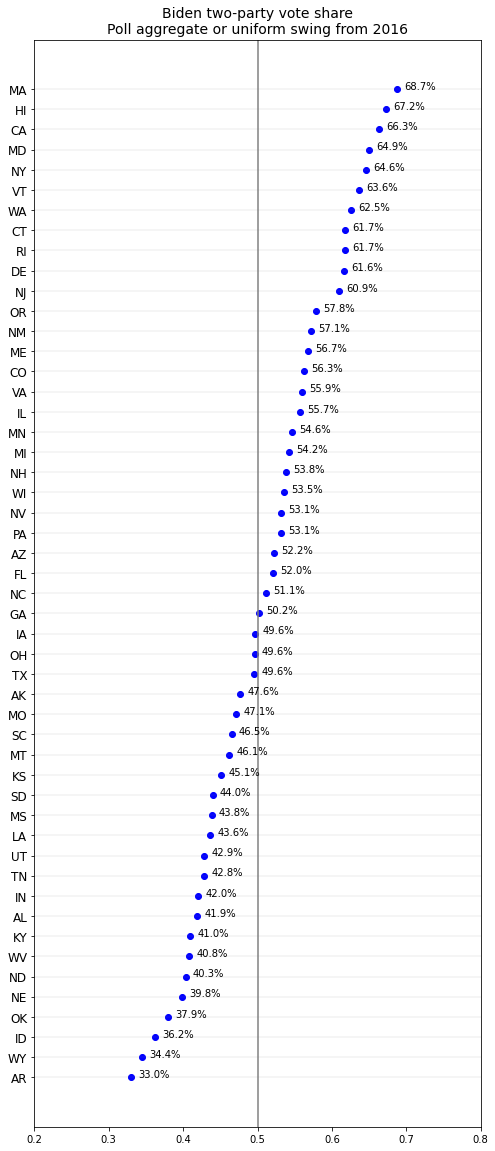

In [63]:
figsize(8,20)

# Don't plot DC
state_mean_sorted = (state_mean.sort_values('biden20_final'))[:-1]

plt.xlim(0.2,0.8)
plt.title('Biden two-party vote share\nPoll aggregate or uniform swing from 2016', fontsize = 14)
plt.yticks(arange(50), state_mean_sorted.index, fontsize = 12)
axvline(0.5, color = 'gray');

plt.scatter(state_mean_sorted.biden20_filled, arange(50), color = 'blue');
for i, state in enumerate(state_mean_sorted.index):
    axhline(i, color = 'gray', alpha = 0.1);
    text(state_mean_sorted.biden20_filled[state] + 0.01, i, 
         '%s%%'%(100*state_mean_sorted.biden20_filled[state]).round(1));

## Simulate election outcome

Increasing the amount of uncertainty in the state poll average and/or the national polling error shifts the probability of winning towards 0.5.

In [64]:
electoral_votes = DataFrame.from_dict({'AL': 9, 'AK': 3, 'AZ': 11, 'AR': 6, 'CA': 55, 'CO': 9,
                                       'CT': 7, 'DE': 3, 'FL': 29, 'GA': 16, 'HI': 4, 'ID': 4,
                                       'IL': 20, 'IN': 11, 'IA': 6, 'KS': 6, 'KY': 8, 'LA': 8,
                                       'ME': 4, 'MD': 10, 'MA': 11, 'MI': 16, 'MN': 10, 'MS': 6,
                                       'MO': 10, 'MT': 3, 'NE': 5, 'NV': 6, 'NH': 4, 'NJ': 14,
                                       'NM': 5, 'NY': 29, 'NC': 15, 'ND': 3, 'OH': 18, 'OK': 7,
                                       'OR': 7, 'PA': 20, 'RI': 4, 'SC': 9, 'SD': 3, 'TN': 11,
                                       'TX': 38, 'UT': 6, 'VT': 3, 'VA': 13, 'WA': 12, 'WV': 5,
                                       'WI': 10, 'WY': 3, 'DC': 3},
                                      orient='index', columns = ['EV'])

In [68]:
# Simulation settings
number_of_simulations = 10000

# Uncertainty in state forecasts, around poll average
state_uncertainty_sd = 0.05

# Uncertainty in national forecasts; correlated error with mean zero
national_uncertainty_sd = 0.03

In [71]:
biden_state_wins = Series(0, index = state_mean.index)
biden_state_votes = DataFrame()
biden_ev_sim = []

for sim in arange(number_of_simulations):
    # simulate 51 state-level election outcomes
    national_error = np.random.normal(0, national_uncertainty_sd)
    one_simulation = DataFrame({'state': state_mean.index,
                                'biden_vote': np.random.normal(state_mean.biden20_final, state_uncertainty_sd) +
                                              national_error}).set_index('state')

    # did Biden win each state in this simulation?
    one_simulation['biden_win'] = (one_simulation.biden_vote > 0.5)+0
    
    # record simulation results
    one_simulation = one_simulation.merge(electoral_votes, left_index = True, right_index = True)
#    print(one_simulation)
    biden_state_wins = biden_state_wins + one_simulation.biden_win
#    print(biden_state_wins)
    biden_state_votes = biden_state_votes.append(one_simulation.biden_vote)
#    print(biden_state_votes)
    biden_ev_sim = biden_ev_sim + [(one_simulation.biden_win * one_simulation.EV).sum()]
#    print(biden_ev_sim)

## Visualize simulation results and chance of winning each state and nationally

- Black line: The result needed to win
- Red line: Simulation average

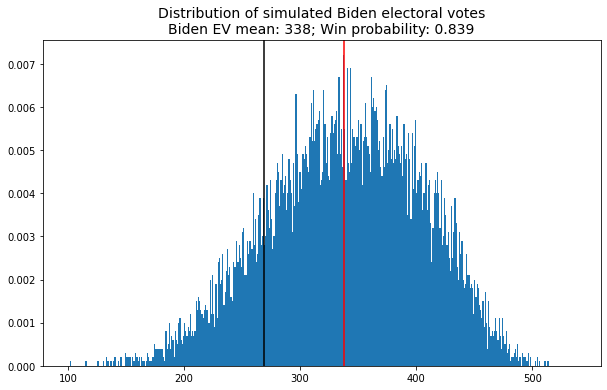

In [72]:
figsize(10,6)
plt.hist(biden_ev_sim, bins = arange(100, 538, 1), density = True);
biden_ev_forecast = int(np.array(biden_ev_sim).mean())
plt.title('Distribution of simulated Biden electoral votes\nBiden EV mean: %s; Win probability: %s'%
          (biden_ev_forecast, (np.array(biden_ev_sim) > 269).mean().round(3)), fontsize = 14);
axvline(269, color = 'black');
axvline(biden_ev_forecast, color = 'red');

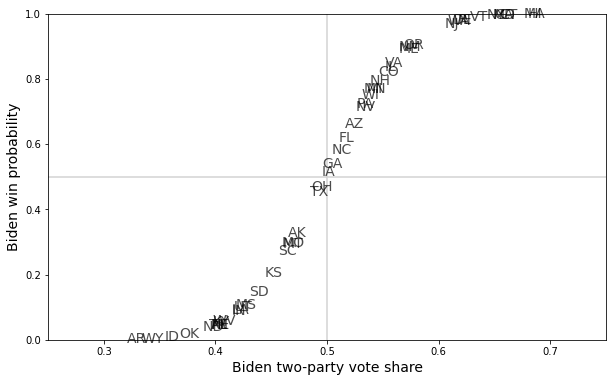

In [24]:
figsize(10,6)
plt.xlim(0.25, 0.75)
plt.xlabel('Biden two-party vote share', fontsize = 14)
plt.ylabel('Biden win probability', fontsize = 14)

biden_state_win_prob = biden_state_wins / number_of_simulations
for state in state_mean.index:
    if state != 'DC':
        plt.text(biden_state_votes.mean()[state],
                 biden_state_win_prob[state],
                 state, ha = 'center', va = 'center', 
                 fontsize = 14, alpha = 0.7)
        
axvline(0.5, color = 'lightgray');
axhline(0.5, color = 'lightgray');

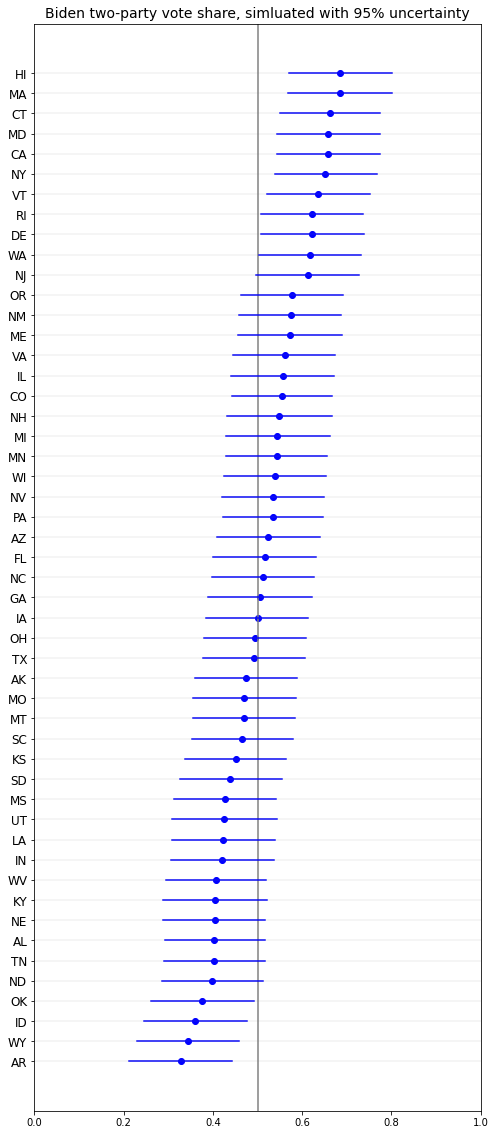

In [25]:
figsize(8,20)

biden_state_votes_sorted = biden_state_votes.mean().sort_values()[:-1]

plt.xlim(0,1)
plt.title('Biden two-party vote share, simluated with 95% uncertainty', fontsize = 14)
plt.yticks(arange(50), biden_state_votes_sorted.index, fontsize = 12)
axvline(0.5, color = 'gray');

plt.scatter(biden_state_votes_sorted, arange(50), color = 'blue');
for i, state in enumerate(biden_state_votes_sorted.index):
    plt.plot([biden_state_votes[state].quantile(0.025), 
              biden_state_votes[state].quantile(0.975)],
              [i, i], color = 'blue');
    axhline(i, color = 'gray', alpha = 0.1);

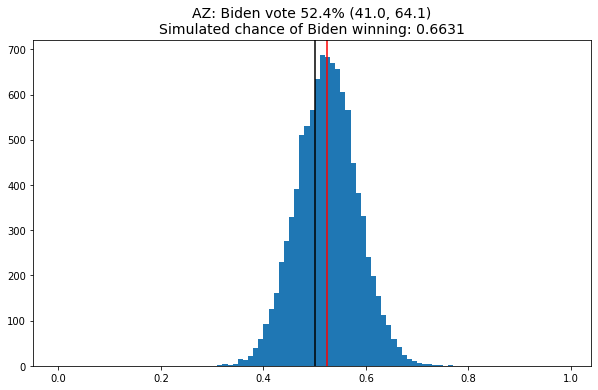

In [26]:
plot_state = 'AZ'

figsize(10,6)
plt.hist(biden_state_votes[plot_state], bins = arange(0,1,0.01));
plt.title('%s: Biden vote %s%% (%s, %s)\nSimulated chance of Biden winning: %s'%(plot_state,
                                                   np.round((100*biden_state_votes[plot_state].mean()),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.025)),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.975)),1),
                                                   biden_state_win_prob[plot_state]),
          fontsize = 14)
axvline(0.5, color = 'black');
axvline(biden_state_votes[plot_state].mean(), color = 'red');